In [10]:
import gc
import tensorflow as tf

def clean_ram():
    """
    Forcefully triggers Python's garbage collector and clears the TensorFlow/Keras session.
    Useful to run between training different models to avoid OOM (Out Of Memory) errors.
    """
    # 1. Clear Keras/TensorFlow backend session
    tf.keras.backend.clear_session()
    
    # 2. Force Python Garbage Collection
    gc.collect()
    
    print("🧹 RAM Cleaned: Keras session cleared & Garbage collected.")

# Usage Example:
# clean_ram()

--- Loading Datasets ---
Data Loaded Successfully.
--- Encoding Labels ---
Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
--- Calculating Class Weights ---
Class Weights Calculated: {0: np.float64(0.8893108455266391), 1: np.float64(0.8893108455266391), 2: np.float64(0.8886160714285715), 3: np.float64(0.8907036581273073), 4: np.float64(0.8886160714285715), 5: np.float64(0.8893108455266391), 6: np.float64(3.949404761904762)}
--- Building Model with Refined Regularization ---


Starting Training with Class Weights...
Epoch 1/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 649s 1s/step - accuracy: 0.6481 - loss: 3.1933 - val_accuracy: 0.7384 - val_loss: 2.8926 - learning_rate: 1.0000e-04
Epoch 2/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 447s 898ms/step - accuracy: 0.8149 - loss: 2.5558 - val_accuracy: 0.7467 - val_loss: 2.7884 - learning_rate: 1.0000e-04
Epoch 3/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 461s 926ms/step - accuracy: 0.8356 - loss: 2.3432 - val_accuracy: 0.7343 - val_loss: 2.6802 - learn

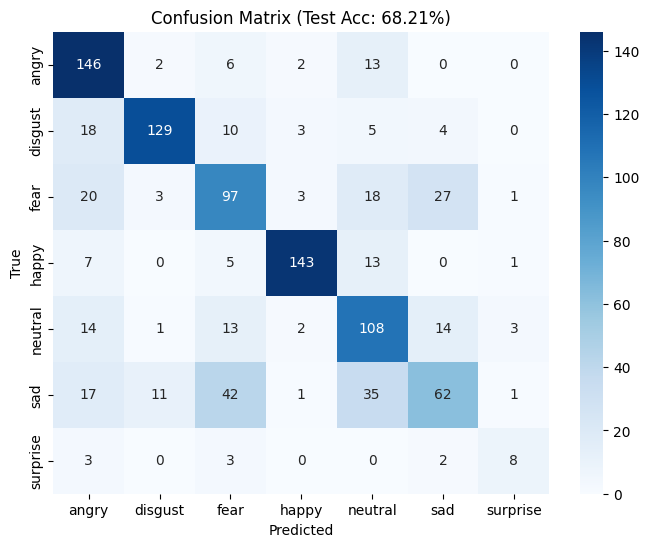

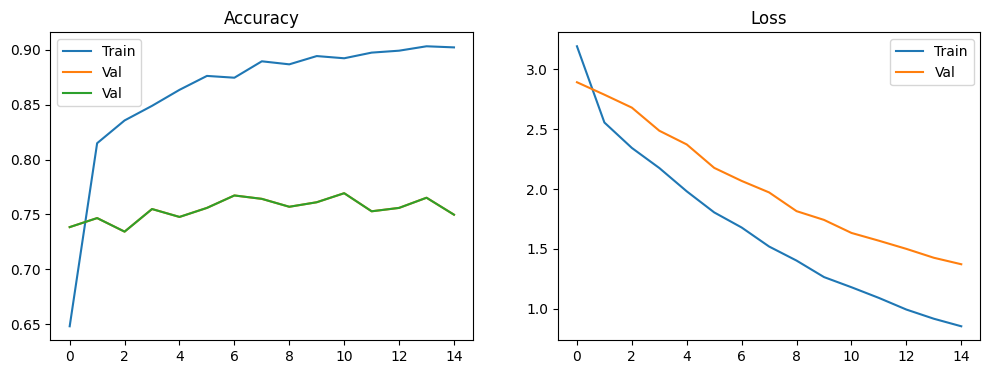

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Multiply, Lambda, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.regularizers import l2 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import os

FACE_PATH = "models_zoo_1/Face_EfficientNet.keras" 
AUDIO_PATH = "models_zoo_1/Audio_EfficientNet_Refined.keras"
SAVE_NAME = "models_zoo_1/Model_Fusion.keras"
DATA_DIR = r"C:\Users\User\Multimodel AI\data_1" 

BATCH_SIZE = 16
EPOCHS = 15 

print("--- Loading Datasets ---")
try:
    train_df = pd.read_csv(os.path.join(DATA_DIR, "train_face.csv"))
    val_df = pd.read_csv(os.path.join(DATA_DIR, "val_face.csv"))
    test_df = pd.read_csv(os.path.join(DATA_DIR, "test_face.csv"))
    
    train_aud = pd.read_csv(os.path.join(DATA_DIR, "train_audio.csv"))
    val_aud = pd.read_csv(os.path.join(DATA_DIR, "val_audio.csv"))
    test_aud = pd.read_csv(os.path.join(DATA_DIR, "test_audio.csv"))
    
    # Clean Columns
    for df in [train_df, val_df, test_df]:
        df.columns = df.columns.str.strip()
        if 'label_str' not in df.columns and 'label' in df.columns:
            df['label_str'] = df['label'].astype(str)
            
    print("Data Loaded Successfully.")

except FileNotFoundError:
    print(f"CRITICAL ERROR: Could not find CSV files in {DATA_DIR}")
    raise

print("--- Encoding Labels ---")
le = LabelEncoder()
all_labels = pd.concat([train_df['label_str'], val_df['label_str'], test_df['label_str']])
le.fit(all_labels)

# Apply encoding to all sets
train_df['label_encoded'] = le.transform(train_df['label_str'])
val_df['label_encoded'] = le.transform(val_df['label_str'])
test_df['label_encoded'] = le.transform(test_df['label_str'])
print(f"Classes: {le.classes_}")

class FusionGenerator(Sequence):
    def __init__(self, face_df, audio_df, batch_size=16, shuffle=True, face_augment=False):
        super().__init__()
        # Merge on original_id to sync face/audio
        self.merged = pd.merge(face_df, audio_df[['original_id', 'audio_path']], on='original_id')
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.face_augment = face_augment # NEW FLAG for augmentation
        self.indices = np.arange(len(self.merged))
        
        if 'audio_path_y' in self.merged.columns:
            self.audio_col = 'audio_path_y'
        else:
            self.audio_col = 'audio_path'

        self.labels = self.merged['label_encoded'].values
        self.on_epoch_end()
        
    def _random_flip(self, image):
        if np.random.rand() < 0.5:
            image = cv2.flip(image, 1) 
        return image

    def _random_crop_and_resize(self, image, size=224):
        s = image.shape
        if self.face_augment and np.random.rand() < 0.3:
            # Randomly pick a crop size between 80% and 100%
            crop_factor = np.random.uniform(0.8, 1.0) 
            new_h, new_w = int(s[0] * crop_factor), int(s[1] * crop_factor)
            
            start_y = np.random.randint(0, s[0] - new_h + 1)
            start_x = np.random.randint(0, s[1] - new_w + 1)
            
            image = image[start_y:start_y + new_h, start_x:start_x + new_w]
        
        return cv2.resize(image, (size, size)) 

    def _random_brightness(self, image):
        if self.face_augment and np.random.rand() < 0.3:
            hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            # Randomly adjust V channel by 80% to 120%
            h, s, v = cv2.split(hsv)
            v = np.clip(v * np.random.uniform(0.8, 1.2), 0, 255).astype(v.dtype)
            hsv = cv2.merge([h, s, v])
            image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        return image

    def __len__(self): return int(np.ceil(len(self.merged) / self.batch_size))
    
    def on_epoch_end(self): 
        if self.shuffle: np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        idxs = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        rows = self.merged.iloc[idxs]
        
        X_f, X_a, y = [], [], []
        for i, (_, row) in enumerate(rows.iterrows()):
            # Face (Load BGR -> Convert RGB)
            img = cv2.imread(row['face_path'])
            if img is None: img = np.zeros((224,224,3))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # RGB Fix
            
            # === APPLY AUGMENTATION FOR TRAINING ONLY ===
            if self.face_augment:
                img = self._random_flip(img)
                img = self._random_brightness(img)
            
            # Cropping/Resizing is applied here (conditionally cropped if face_augment is True)
            img = self._random_crop_and_resize(img, size=224) 

            # Preprocess
            img = tf.keras.applications.efficientnet.preprocess_input(img.astype(float))
            X_f.append(img)
            
            # Audio
            spec = np.load(row[self.audio_col])
            spec = cv2.resize(spec, (224, 224))
            if len(spec.shape)==2: spec = np.stack((spec,)*3, axis=-1)
            if np.max(spec) <= 1.0: spec = spec * 255.0
            spec = tf.keras.applications.efficientnet.preprocess_input(spec.astype(float))
            X_a.append(spec)
            
            y.append(self.labels[idxs[i]])
        
        inputs = { "face_input_new": np.array(X_f), "audio_input_new": np.array(X_a) }
        return inputs, to_categorical(y, num_classes=7)

def build_model():
    print("--- Building Model with Refined Regularization ---")
    # safe_mode=False is usually only needed for loading custom layers, but use it to be robust
    face_base = load_model(FACE_PATH, compile=False, safe_mode=False) 
    audio_base = load_model(AUDIO_PATH, compile=False, safe_mode=False)
    
    # Create Feature Extractors (Frozen)
    face_extractor = Model(inputs=face_base.input, outputs=face_base.layers[-3].output, name="face_extractor")
    audio_extractor = Model(inputs=audio_base.input, outputs=audio_base.layers[-3].output, name="audio_extractor")
    
    face_extractor.trainable = False
    audio_extractor.trainable = False
    
    # Inputs
    input_f = Input(shape=(224, 224, 3), name="face_input_new")
    input_a = Input(shape=(224, 224, 3), name="audio_input_new")
    
    # Features
    f_feat = face_extractor(input_f)
    a_feat = audio_extractor(input_a)
    
    # Gated Fusion
    concat = Concatenate(name="fusion_concat")([f_feat, a_feat])
    z = Dense(1, activation="sigmoid", name="fusion_gate")(concat) 
    
    f_w = Multiply(name="face_weighted")([f_feat, z])
    inverse_gate = Lambda(lambda x: 1.0 - x, name="inverse_gate")(z)
    a_w = Multiply(name="audio_weighted")([a_feat, inverse_gate])
    
    merged = Concatenate(name="weighted_concat")([f_w, a_w])
    
    # --- CLASSIFIER WITH MODIFIED REGULARIZATION ---
    # L2 Regularization slightly reduced to 0.005
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.005), name="fusion_dense")(merged)
    x = BatchNormalization(name="fusion_bn")(x)
    # Dropout slightly reduced to 0.5
    x = Dropout(0.5, name="fusion_dropout")(x)
    out = Dense(7, activation='softmax', name="fusion_output")(x)
    
    model = Model(inputs=[input_f, input_a], outputs=out, name="Gated_Fusion_Model")
    return model

print("--- Calculating Class Weights ---")
# Build & Compile
# Initialize TRAIN generator WITH augmentation
gen_train = FusionGenerator(train_df, train_aud, batch_size=BATCH_SIZE, face_augment=True)
# Initialize VAL generator WITHOUT augmentation
gen_val = FusionGenerator(val_df, val_aud, batch_size=BATCH_SIZE, face_augment=False)

# Calculate Weights
y_train = gen_train.labels 
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights Calculated: {class_weights_dict}")

model = build_model()
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

print("\nStarting Training with Class Weights...")
history = model.fit(
    gen_train,
    validation_data=gen_val,
    epochs=EPOCHS,
    class_weight=class_weights_dict, 
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True), # Increased patience
        ModelCheckpoint(SAVE_NAME, save_best_only=True, monitor='val_accuracy'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
    ]
)

print("\n--- Final Evaluation on Test Set ---")
gen_test = FusionGenerator(test_df, test_aud, batch_size=BATCH_SIZE, shuffle=False, face_augment=False)

# Predict
y_pred_probs = model.predict(gen_test, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get True Labels safely
y_true = gen_test.merged['label_encoded'].values[:len(y_pred)]

# Metrics
acc = accuracy_score(y_true, y_pred)
print(f"\nFINAL TEST ACCURACY: {acc:.4f}")
print("-" * 30)
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix (Test Acc: {acc:.2%})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

--- Loading Datasets ---
Data Loaded Successfully.
--- Encoding Labels ---
Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
--- Calculating Class Weights ---
Class Weights Calculated: {0: np.float64(0.8893108455266391), 1: np.float64(0.8893108455266391), 2: np.float64(0.8886160714285715), 3: np.float64(0.8907036581273073), 4: np.float64(0.8886160714285715), 5: np.float64(0.8893108455266391), 6: np.float64(3.949404761904762)}
--- Building Model with Refined Regularization ---


Starting Training with Class Weights...
Epoch 1/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 375s 731ms/step - accuracy: 0.5278 - loss: 3.6052 - val_accuracy: 0.6612 - val_loss: 3.0955 - learning_rate: 1.0000e-04
Epoch 2/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 387s 777ms/step - accuracy: 0.6835 - loss: 2.9941 - val_accuracy: 0.7106 - val_loss: 2.9209 - learning_rate: 1.0000e-04
Epoch 3/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 378s 758ms/step - accuracy: 0.7317 - loss: 2.7290 - val_accuracy: 0.7178 - val_loss: 2.7682 - le

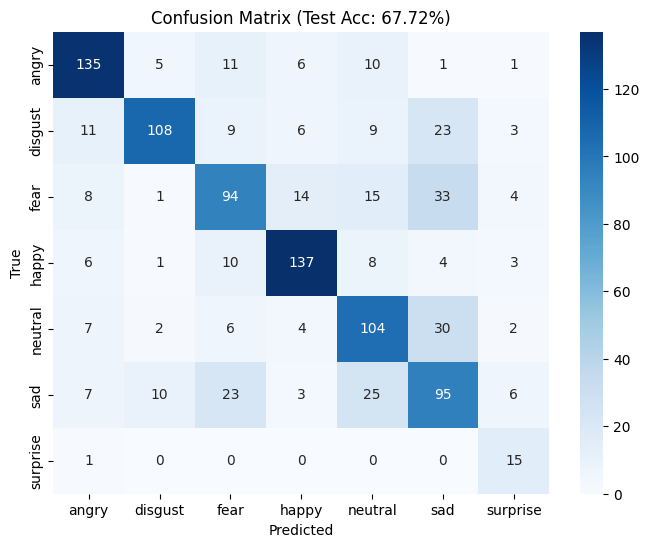

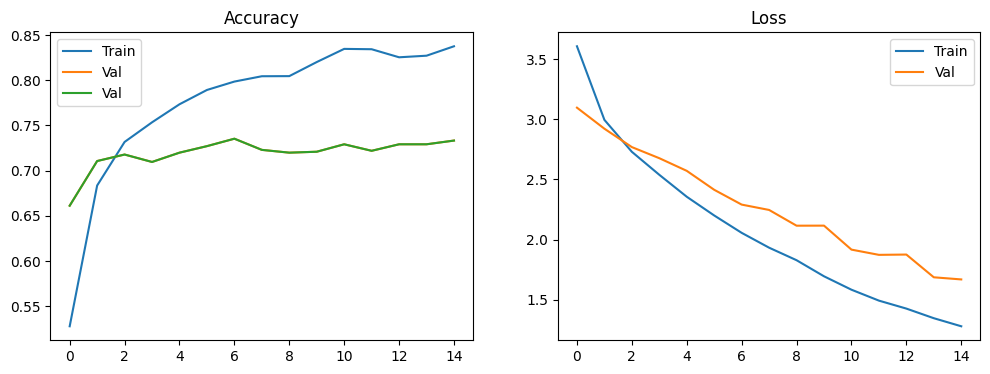

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Multiply, Lambda, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.regularizers import l2 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import os

FACE_PATH = "models_zoo_1/efficientnet_improved.keras" 
AUDIO_PATH = "models_zoo_1/Audio_EfficientNet_Refined.keras"
SAVE_NAME = "models_zoo_1/modelfusion_2.keras"
DATA_DIR = r"C:\Users\User\Multimodel AI\data_1" 

BATCH_SIZE = 16
EPOCHS = 30 # Increased for more training time

print("--- Loading Datasets ---")
try:
    train_df = pd.read_csv(os.path.join(DATA_DIR, "train_face.csv"))
    val_df = pd.read_csv(os.path.join(DATA_DIR, "val_face.csv"))
    test_df = pd.read_csv(os.path.join(DATA_DIR, "test_face.csv"))
    
    train_aud = pd.read_csv(os.path.join(DATA_DIR, "train_audio.csv"))
    val_aud = pd.read_csv(os.path.join(DATA_DIR, "val_audio.csv"))
    test_aud = pd.read_csv(os.path.join(DATA_DIR, "test_audio.csv"))
    
    # Clean Columns
    for df in [train_df, val_df, test_df]:
        df.columns = df.columns.str.strip()
        if 'label_str' not in df.columns and 'label' in df.columns:
            df['label_str'] = df['label'].astype(str)
            
    print("Data Loaded Successfully.")

except FileNotFoundError:
    print(f"CRITICAL ERROR: Could not find CSV files in {DATA_DIR}")
    raise

print("--- Encoding Labels ---")
le = LabelEncoder()
all_labels = pd.concat([train_df['label_str'], val_df['label_str'], test_df['label_str']])
le.fit(all_labels)

# Apply encoding to all sets
train_df['label_encoded'] = le.transform(train_df['label_str'])
val_df['label_encoded'] = le.transform(val_df['label_str'])
test_df['label_encoded'] = le.transform(test_df['label_str'])
print(f"Classes: {le.classes_}")

class FusionGenerator(Sequence):
    def __init__(self, face_df, audio_df, batch_size=16, shuffle=True, face_augment=False):
        super().__init__()
        # Merge on original_id to sync face/audio
        self.merged = pd.merge(face_df, audio_df[['original_id', 'audio_path']], on='original_id')
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.face_augment = face_augment # NEW FLAG for augmentation
        self.indices = np.arange(len(self.merged))
        
        if 'audio_path_y' in self.merged.columns:
            self.audio_col = 'audio_path_y'
        else:
            self.audio_col = 'audio_path'

        self.labels = self.merged['label_encoded'].values
        self.on_epoch_end()
        
    def _random_flip(self, image):
        if np.random.rand() < 0.5:
            image = cv2.flip(image, 1) 
        return image

    def _random_crop_and_resize(self, image, size=224):
        s = image.shape
        if self.face_augment and np.random.rand() < 0.3:
            # Randomly pick a crop size between 80% and 100%
            crop_factor = np.random.uniform(0.8, 1.0) 
            new_h, new_w = int(s[0] * crop_factor), int(s[1] * crop_factor)
            
            start_y = np.random.randint(0, s[0] - new_h + 1)
            start_x = np.random.randint(0, s[1] - new_w + 1)
            
            image = image[start_y:start_y + new_h, start_x:start_x + new_w]
        
        return cv2.resize(image, (size, size)) 

    def _random_brightness(self, image):
        if self.face_augment and np.random.rand() < 0.3:
            hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            # Randomly adjust V channel by 80% to 120%
            h, s, v = cv2.split(hsv)
            v = np.clip(v * np.random.uniform(0.8, 1.2), 0, 255).astype(v.dtype)
            hsv = cv2.merge([h, s, v])
            image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        return image

    def __len__(self): return int(np.ceil(len(self.merged) / self.batch_size))
    
    def on_epoch_end(self): 
        if self.shuffle: np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        idxs = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        rows = self.merged.iloc[idxs]
        
        X_f, X_a, y = [], [], []
        for i, (_, row) in enumerate(rows.iterrows()):
            # Face (Load BGR -> Convert RGB)
            img = cv2.imread(row['face_path'])
            if img is None: img = np.zeros((224,224,3))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # RGB Fix
            
            # === APPLY AUGMENTATION FOR TRAINING ONLY ===
            if self.face_augment:
                img = self._random_flip(img)
                img = self._random_brightness(img)
            
            # Cropping/Resizing is applied here (conditionally cropped if face_augment is True)
            img = self._random_crop_and_resize(img, size=224) 

            # Preprocess
            img = tf.keras.applications.efficientnet.preprocess_input(img.astype(float))
            X_f.append(img)
            
            # Audio
            spec = np.load(row[self.audio_col])
            spec = cv2.resize(spec, (224, 224))
            if len(spec.shape)==2: spec = np.stack((spec,)*3, axis=-1)
            if np.max(spec) <= 1.0: spec = spec * 255.0
            spec = tf.keras.applications.efficientnet.preprocess_input(spec.astype(float))
            X_a.append(spec)
            
            y.append(self.labels[idxs[i]])
        
        inputs = { "face_input_new": np.array(X_f), "audio_input_new": np.array(X_a) }
        return inputs, to_categorical(y, num_classes=7)

def build_model():
    print("--- Building Model with Refined Regularization ---")
    # safe_mode=False is usually only needed for loading custom layers, but use it to be robust
    face_base = load_model(FACE_PATH, compile=False, safe_mode=False) 
    audio_base = load_model(AUDIO_PATH, compile=False, safe_mode=False)
    
    # Create Feature Extractors (Frozen)
    face_extractor = Model(inputs=face_base.input, outputs=face_base.layers[-3].output, name="face_extractor")
    audio_extractor = Model(inputs=audio_base.input, outputs=audio_base.layers[-3].output, name="audio_extractor")
    
    face_extractor.trainable = False
    audio_extractor.trainable = False
    
    # Inputs
    input_f = Input(shape=(224, 224, 3), name="face_input_new")
    input_a = Input(shape=(224, 224, 3), name="audio_input_new")
    
    # Features
    f_feat = face_extractor(input_f)
    a_feat = audio_extractor(input_a)
    
    # Gated Fusion
    concat = Concatenate(name="fusion_concat")([f_feat, a_feat])
    z = Dense(1, activation="sigmoid", name="fusion_gate")(concat) 
    
    f_w = Multiply(name="face_weighted")([f_feat, z])
    inverse_gate = Lambda(lambda x: 1.0 - x, name="inverse_gate")(z)
    a_w = Multiply(name="audio_weighted")([a_feat, inverse_gate])
    
    merged = Concatenate(name="weighted_concat")([f_w, a_w])
    
    # --- CLASSIFIER WITH MODIFIED REGULARIZATION ---
    # L2 Regularization slightly reduced to 0.005
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.005), name="fusion_dense")(merged)
    x = BatchNormalization(name="fusion_bn")(x)
    # Dropout slightly reduced to 0.5
    x = Dropout(0.5, name="fusion_dropout")(x)
    out = Dense(7, activation='softmax', name="fusion_output")(x)
    
    model = Model(inputs=[input_f, input_a], outputs=out, name="Gated_Fusion_Model")
    return model

print("--- Calculating Class Weights ---")
# Build & Compile
# Initialize TRAIN generator WITH augmentation
gen_train = FusionGenerator(train_df, train_aud, batch_size=BATCH_SIZE, face_augment=True)
# Initialize VAL generator WITHOUT augmentation
gen_val = FusionGenerator(val_df, val_aud, batch_size=BATCH_SIZE, face_augment=False)

# Calculate Weights
y_train = gen_train.labels 
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights Calculated: {class_weights_dict}")

model = build_model()
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

print("\nStarting Training with Class Weights...")
history = model.fit(
    gen_train,
    validation_data=gen_val,
    epochs=EPOCHS,
    class_weight=class_weights_dict, 
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True), # Increased patience
        ModelCheckpoint(SAVE_NAME, save_best_only=True, monitor='val_accuracy'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
    ]
)

print("\n--- Final Evaluation on Test Set ---")
gen_test = FusionGenerator(test_df, test_aud, batch_size=BATCH_SIZE, shuffle=False, face_augment=False)

# Predict
y_pred_probs = model.predict(gen_test, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get True Labels safely
y_true = gen_test.merged['label_encoded'].values[:len(y_pred)]

# Metrics
acc = accuracy_score(y_true, y_pred)
print(f"\nFINAL TEST ACCURACY: {acc:.4f}")
print("-" * 30)
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix (Test Acc: {acc:.2%})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

In [10]:
pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
    --------------------------------------- 1.0/72.0 MB 20.8 MB/s eta 0:00:04
   - -------------------------------------- 3.1/72.0 MB 11.6 MB/s eta 0:00:06
   -- ------------------------------------- 3.9/72.0 MB 11.3 MB/s eta 0:00:07
   -- ------------------------------------- 4.2/72.0 MB 5.8 MB/s eta 0:00:12
   --- ------------------------------------ 6.0/72.0 MB 6.8 MB/s eta 0:00:10
   ---- ----------------------------------- 7.3/72.0 MB 6.3 MB/s eta 0:00:11
   ---- ----------------------------------- 8.7/72.0 MB 6.4 MB/s eta 0:00:10
   ----- ---------------------------------- 9.4/72.0 MB 6.1 MB/s eta 0:00:11
   ----- ---------------------------------- 10.2/72.0 MB 5.7 MB/s eta 0:00:11
   ----- ---------------------------------- 10.5/72.0 MB 5.5 MB/s eta 0:00:12
   ------ --------------------------------- 11.0/72.0 MB 5.0 MB/s eta 0:00:13
   ------ --------------------------------- 11.8/72.0 MB 4.9 MB/s eta 0:00:13

In [7]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm

# --- 1. CONFIGURATION ---
DATA_DIR = r"C:\Users\User\Multimodel AI\data_1"
BATCH_SIZE = 16
PATH_FUSION = "models_zoo_1/modelfusion_2.keras"
PATH_FACE   = "models_zoo_1/efficientnet_improved.keras"
PATH_AUDIO  = "models_zoo_1/Audio_EfficientNet_Refined.keras" 

# Check for XGBoost
try:
    from xgboost import XGBClassifier
    USE_XGB = True
except ImportError:
    USE_XGB = False

# --- 2. DATA LOADING (CORRECTED) ---
print("\n--- Loading Data ---")
val_df   = pd.read_csv(os.path.join(DATA_DIR, "val_face.csv"))
test_df  = pd.read_csv(os.path.join(DATA_DIR, "test_face.csv"))
val_aud  = pd.read_csv(os.path.join(DATA_DIR, "val_audio.csv"))
test_aud = pd.read_csv(os.path.join(DATA_DIR, "test_audio.csv"))
train_df = pd.read_csv(os.path.join(DATA_DIR, "train_face.csv"))

# 1. Clean Column Names (Crucial step from previous cells)
for df in [train_df, val_df, test_df, val_aud, test_aud]:
    df.columns = df.columns.str.strip()

# 2. Encode Labels (Fixed Syntax)
le = LabelEncoder()

# Concatenate first, THEN convert to string
all_labels = pd.concat([
    train_df['label'], 
    val_df['label'], 
    test_df['label']
], axis=0).astype(str)

le.fit(all_labels)

# Apply encoding
val_df['label_str'] = le.transform(val_df['label'].astype(str))
test_df['label_str'] = le.transform(test_df['label'].astype(str))
y_val = val_df['label_str'].values
y_test = test_df['label_str'].values

print(f"Classes: {le.classes_}")

# --- 3. GENERATOR ---
class FusionGenerator(Sequence):
    def __init__(self, face_df, audio_df, batch_size=16):
        self.merged = pd.merge(face_df, audio_df[['original_id', 'audio_path']], on='original_id')
        self.batch_size = batch_size
        self.indices = np.arange(len(self.merged))
        self.audio_col = 'audio_path_y' if 'audio_path_y' in self.merged.columns else 'audio_path'
        self.labels = self.merged['label_str'].values

    def __len__(self): return int(np.ceil(len(self.merged) / self.batch_size))
    
    def __getitem__(self, idx):
        idxs = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        rows = self.merged.iloc[idxs]
        X_f, X_a, y = [], [], []
        for i, (_, row) in enumerate(rows.iterrows()):
            img = cv2.imread(row['face_path'])
            if img is None: img = np.zeros((224,224,3), dtype=np.uint8)
            img = eff_preprocess(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (224, 224)).astype(float))
            X_f.append(img)
            
            spec = np.load(row[self.audio_col])
            spec = cv2.resize(spec, (224, 224))
            if len(spec.shape)==2: spec = np.stack((spec,)*3, axis=-1)
            if np.max(spec) <= 1.0: spec = spec * 255.0
            X_a.append(eff_preprocess(spec.astype(float)))
            y.append(self.labels[idxs[i]])
        return { "face_input_new": np.array(X_f), "audio_input_new": np.array(X_a) }, to_categorical(y, num_classes=len(le.classes_))

# --- 4. PREDICTION WITH TTA (TEST TIME AUGMENTATION) ---
def get_tta_predictions(fusion_path, face_path, audio_path, generator, desc="Predicting"):
    print(f"\n--- Loading Base Models for {desc} (With TTA) ---")
    m_face   = load_model(face_path, compile=False)
    m_audio  = load_model(audio_path, compile=False)
    m_fusion = load_model(fusion_path, compile=False, safe_mode=False)

    p_fus, p_fac, p_aud = [], [], []
    
    for batch_X, _ in tqdm(generator):
        # 1. Standard Prediction
        pred_face_1 = m_face.predict(batch_X['face_input_new'], verbose=0)
        
        # 2. Flipped Prediction (TTA) - The "Magic" Step
        # Flip the batch of images horizontally
        X_flip = np.array([cv2.flip(img, 1) for img in batch_X['face_input_new']])
        pred_face_2 = m_face.predict(X_flip, verbose=0)
        
        # Average the two face predictions
        avg_face = (pred_face_1 + pred_face_2) / 2.0
        p_fac.append(avg_face)
        
        # Audio & Fusion don't get flipped
        p_aud.append(m_audio.predict(batch_X['audio_input_new'], verbose=0))
        p_fus.append(m_fusion.predict(batch_X, verbose=0))

    return np.vstack(p_fus), np.vstack(p_fac), np.vstack(p_aud)

# Generate Predictions with TTA
print("Generating TTA Predictions (This may take a moment)...")
val_gen = FusionGenerator(val_df, val_aud, batch_size=BATCH_SIZE)
val_fusion, val_face, val_audio = get_tta_predictions(PATH_FUSION, PATH_FACE, PATH_AUDIO, val_gen, "Validation")

test_gen = FusionGenerator(test_df, test_aud, batch_size=BATCH_SIZE)
test_fusion, test_face, test_audio = get_tta_predictions(PATH_FUSION, PATH_FACE, PATH_AUDIO, test_gen, "Test")

# --- 5. FEATURE ENGINEERING ---
def create_meta_features(fusion_p, face_p, audio_p):
    base_features = np.hstack([fusion_p, face_p, audio_p])
    # Hints
    agreement = (np.argmax(face_p, axis=1) == np.argmax(audio_p, axis=1)).astype(float).reshape(-1, 1)
    max_p = np.max(base_features, axis=1, keepdims=True)
    return np.hstack([base_features, agreement, max_p])

X_val_meta = create_meta_features(val_fusion, val_face, val_audio)
X_test_meta = create_meta_features(test_fusion, test_face, test_audio)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_val)

# --- 6. DUAL STACKING (XGBoost + LogisticRegression) ---
print("\n--- Training Dual Stack Ensemble ---")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_test_preds = []

for fold, (train_idx, valid_idx) in enumerate(skf.split(X_val_meta, y_val)):
    X_train, X_valid = X_val_meta[train_idx], X_val_meta[valid_idx]
    y_train, y_valid = y_val[train_idx], y_val[valid_idx]
    
    # Model 1: XGBoost (Non-linear Expert)
    if USE_XGB:
        m1 = XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=2, 
                           min_child_weight=5, gamma=1.0, subsample=0.7, 
                           colsample_bytree=0.6, early_stopping_rounds=50)
        m1.fit(X_train, y_train, sample_weight=sample_weights[train_idx], 
               eval_set=[(X_valid, y_valid)], verbose=0)
        p1 = m1.predict_proba(X_test_meta)
    else:
        p1 = np.zeros((len(X_test_meta), len(le.classes_))) # Skip if no XGB
        
    # Model 2: Logistic Regression (Linear Safety Net)
    m2 = LogisticRegression(class_weight='balanced', C=0.01, max_iter=1000)
    m2.fit(X_train, y_train)
    p2 = m2.predict_proba(X_test_meta)
    
    # Soft Voting: Average them (50/50 split usually best for stability)
    if USE_XGB:
        final_test_preds.append((p1 + p2) / 2)
    else:
        final_test_preds.append(p2)
    
    print(f"Fold {fold+1} Done.")

# --- 7. EVALUATION ---
avg_probs = np.mean(final_test_preds, axis=0)
final_preds = np.argmax(avg_probs, axis=1)

print("\n" + "="*50)
print(f"FINAL TTA+STACK ACCURACY: {accuracy_score(y_test, final_preds):.4f}")
print("="*50)
print(classification_report(y_test, final_preds, target_names=le.classes_))


--- Loading Data ---
Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Generating TTA Predictions (This may take a moment)...

--- Loading Base Models for Validation (With TTA) ---


100%|██████████| 61/61 [05:51<00:00,  5.77s/it]



--- Loading Base Models for Test (With TTA) ---


100%|██████████| 64/64 [03:27<00:00,  3.25s/it]



--- Training Dual Stack Ensemble ---
Fold 1 Done.
Fold 2 Done.
Fold 3 Done.
Fold 4 Done.
Fold 5 Done.

FINAL TTA+STACK ACCURACY: 0.7185
              precision    recall  f1-score   support

       angry       0.79      0.85      0.81       169
     disgust       0.87      0.72      0.79       169
        fear       0.61      0.59      0.60       169
       happy       0.93      0.82      0.87       169
     neutral       0.65      0.74      0.69       155
         sad       0.55      0.57      0.56       169
    surprise       0.56      0.94      0.70        16

    accuracy                           0.72      1016
   macro avg       0.71      0.75      0.72      1016
weighted avg       0.73      0.72      0.72      1016



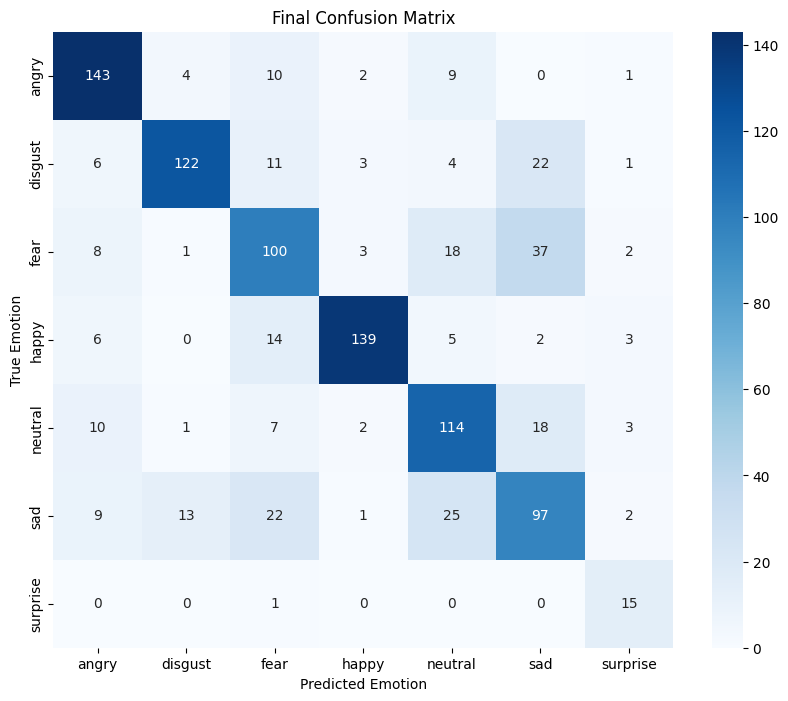


--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

       angry       0.79      0.85      0.81       169
     disgust       0.87      0.72      0.79       169
        fear       0.61      0.59      0.60       169
       happy       0.93      0.82      0.87       169
     neutral       0.65      0.74      0.69       155
         sad       0.55      0.57      0.56       169
    surprise       0.56      0.94      0.70        16

    accuracy                           0.72      1016
   macro avg       0.71      0.75      0.72      1016
weighted avg       0.73      0.72      0.72      1016



In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- 1. CONFIGURATION ---
CLASSES = le.classes_

# --- 2. GENERATE CONFUSION MATRIX ---
cm = confusion_matrix(y_test, final_preds)

# --- 3. PLOT HEATMAP ---
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title(f"Final Confusion Matrix")
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.show()

# --- 4. DETAILED REPORT ---
print("\n--- FINAL CLASSIFICATION REPORT ---")
print(classification_report(y_test, final_preds, target_names=CLASSES))

In [9]:
import joblib

# --- 1. TRAIN FINAL META-LEARNERS (ON FULL VALIDATION SET) ---
# We use the entire validation set as the 'training ground' for the meta-learner
print("Training final meta-learners for deployment...")

# Final XGBoost
final_xgb = XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=2, 
                          min_child_weight=5, gamma=1.0, subsample=0.7, 
                          colsample_bytree=0.6, early_stopping_rounds=50)
final_xgb.fit(X_val_meta, y_val, sample_weight=sample_weights, 
              eval_set=[(X_val_meta, y_val)], verbose=0)

# Final Logistic Regression
final_logreg = LogisticRegression(class_weight='balanced', C=0.01, max_iter=1000)
final_logreg.fit(X_val_meta, y_val)

print("Final meta-learners trained.")

# --- 2. SAVE EVERYTHING ---
SAVE_DIR = "ensemble_system_v1"
if not os.path.exists(SAVE_DIR): os.makedirs(SAVE_DIR)

# Save Meta-Models
joblib.dump(final_xgb, os.path.join(SAVE_DIR, "meta_xgboost.pkl"))
joblib.dump(final_logreg, os.path.join(SAVE_DIR, "meta_logreg.pkl"))
joblib.dump(le, os.path.join(SAVE_DIR, "label_encoder.pkl"))

print(f"System saved to folder: {SAVE_DIR}/")
print("   - meta_xgboost.pkl")
print("   - meta_logreg.pkl")
print("   - label_encoder.pkl")
print("   (Ensure you keep your 'models_zoo_1' folder safe too!)")

Training final meta-learners for deployment...
Final meta-learners trained.
System saved to folder: ensemble_system_v1/
   - meta_xgboost.pkl
   - meta_logreg.pkl
   - label_encoder.pkl
   (Ensure you keep your 'models_zoo_1' folder safe too!)


In [10]:
import os
import shutil

# --- CONFIGURATION ---
SOURCE_DIR = "ensemble_system_v1"
DEST_DIR = "models_zoo_1"

# The 3 specific files we need to move
FILES_TO_MOVE = [
    "meta_xgboost.pkl",
    "meta_logreg.pkl",
    "label_encoder.pkl"
]

def move_ensemble_files():
    # 1. Check if Source Directory Exists
    if not os.path.exists(SOURCE_DIR):
        print(f"Error: Source folder '{SOURCE_DIR}' not found.")
        print("   Did you run the previous training block?")
        return

    # 2. Check/Create Destination Directory
    if not os.path.exists(DEST_DIR):
        print(f"Destination '{DEST_DIR}' not found. Creating it...")
        os.makedirs(DEST_DIR)

    print(f"Moving files from '{SOURCE_DIR}' -> '{DEST_DIR}'...\n")

    # 3. Move Files Loop
    for filename in FILES_TO_MOVE:
        src_path = os.path.join(SOURCE_DIR, filename)
        dst_path = os.path.join(DEST_DIR, filename)

        if os.path.exists(src_path):
            try:
                # If file already exists in destination, replace it
                if os.path.exists(dst_path):
                    os.remove(dst_path)
                
                shutil.move(src_path, dst_path)
                print(f"Moved: {filename}")
            except Exception as e:
                print(f"Failed to move {filename}: {e}")
        else:
            # Check if it's already in the destination (user might have moved it manually)
            if os.path.exists(dst_path):
                print(f"{filename} is already in the destination folder.")
            else:
                print(f" Missing: {filename} not found in source or destination.")

    # 4. Final Verification
    print("\n--- FINAL VERIFICATION ---")
    required_files = [
        "Face_EfficientNet.keras",
        "Audio_EfficientNet_Refined.keras",
        "Model_Fusion.keras",
        "meta_xgboost.pkl",
        "meta_logreg.pkl",
        "label_encoder.pkl"
    ]
    
    missing_files = []
    print(f"Checking '{DEST_DIR}' for all required system files:")
    for f in required_files:
        f_path = os.path.join(DEST_DIR, f)
        if os.path.exists(f_path):
            print(f"   [OK] {f}")
        else:
            print(f"   [MISSING] {f}")
            missing_files.append(f)

    print("-" * 30)
    if not missing_files:
        print("SUCCESS! Your 'models_zoo_1' folder is ready for Streamlit.")
    else:
        print("WARNING: Some files are still missing. Check the list above.")

if __name__ == "__main__":
    move_ensemble_files()

Moving files from 'ensemble_system_v1' -> 'models_zoo_1'...

Moved: meta_xgboost.pkl
Moved: meta_logreg.pkl
Moved: label_encoder.pkl

--- FINAL VERIFICATION ---
Checking 'models_zoo_1' for all required system files:
   [OK] Face_EfficientNet.keras
   [OK] Audio_EfficientNet_Refined.keras
   [OK] Model_Fusion.keras
   [OK] meta_xgboost.pkl
   [OK] meta_logreg.pkl
   [OK] label_encoder.pkl
------------------------------
SUCCESS! Your 'models_zoo_1' folder is ready for Streamlit.


In [15]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import joblib

# --- 1. SETUP CANDIDATES ---
print("\n--- Comparing Meta-Learner Candidates ---")

# Define the individual models
model_lr  = LogisticRegression(class_weight='balanced', C=0.01, max_iter=1000)
model_xgb = XGBClassifier(n_estimators=500, learning_rate=0.01, max_depth=2, subsample=0.7)
model_rf  = RandomForestClassifier(n_estimators=200, max_depth=8, class_weight='balanced', random_state=42)

# Define the "Ensembles" (Combinations)
candidates = {
    "Logistic Regression ": model_lr,
    "XGBoost": model_xgb,
    "Random Forest": model_rf,
    "Ensemble: XGB + LR ": VotingClassifier(
        estimators=[('xgb', model_xgb), ('lr', model_lr)], voting='soft'),
    "Ensemble: XGB + RF": VotingClassifier(
        estimators=[('xgb', model_xgb), ('rf', model_rf)], voting='soft'),
    "Ensemble: RF + LR": VotingClassifier(
        estimators=[('rf', model_rf), ('lr', model_lr)], voting='soft')
}

# --- 2. TRAIN & EVALUATE ---
results = []

for name, model in candidates.items():
    # Train on Validation Meta-Features
    model.fit(X_val_meta, y_val)
    
    # Predict on Test Meta-Features
    preds = model.predict(X_test_meta)
    acc = accuracy_score(y_test, preds)
    
    results.append({"Meta-Model": name, "Test Accuracy": acc})
    print(f"Done: {name} | Accuracy: {acc:.4f}")

# --- 3. SUMMARY TABLE ---
results_df = pd.DataFrame(results).sort_values(by="Test Accuracy", ascending=False)
print("\n" + "="*50)
print("FINAL COMPARISON RESULTS")
print("="*50)
print(results_df.to_string(index=False))


--- Comparing Meta-Learner Candidates ---
Done: Logistic Regression  | Accuracy: 0.7028
Done: XGBoost | Accuracy: 0.7067
Done: Random Forest | Accuracy: 0.7087
Done: Ensemble: XGB + LR  | Accuracy: 0.7106
Done: Ensemble: XGB + RF | Accuracy: 0.7106
Done: Ensemble: RF + LR | Accuracy: 0.7096

FINAL COMPARISON RESULTS
          Meta-Model  Test Accuracy
  Ensemble: XGB + RF       0.710630
 Ensemble: XGB + LR        0.710630
   Ensemble: RF + LR       0.709646
       Random Forest       0.708661
             XGBoost       0.706693
Logistic Regression        0.702756
